In [1]:
import training
import numpy as np
from paths import RESULTS_FILTERED_DIR, RESULTS_UNFILTERED_DIR
from model_selection import rank_models, plot_model_losses, haversine_np
from save_results import load_scaler, plot_samples
import pickle

In [5]:
device = training.determine_device()
print("Using device:", device)

Using device: cpu


In [6]:
metrics = ["val_mse", "val_rmse", "val_mae"]
best_model_name, best_score, best_model_data = rank_models(RESULTS_FILTERED_DIR, metrics[0])

Best validation MSE per model (sorted): 

1. small_seq2seq_trans            best MSE = 0.000431
2. mini_seq2seq_trans             best MSE = 0.000647
3. small_seq2seq_trans            best MSE = 0.000837
4. twolayer_seq2seq_trans         best MSE = 0.001039
5. medium_seq2seq_trans           best MSE = 0.001125
6. dropoutincrease_seq2seq_trans  best MSE = 0.001321
7. deep_seq2seq_trans             best MSE = 0.001887
8. deeper_autoreg_lstm_2          best MSE = 0.005887
9. deeper_autoreg_lstm            best MSE = 0.006013
10. medium_autoreg_lstm            best MSE = 0.006168
11. deeper_lstm_2                  best MSE = 0.006291
12. deeper_lstm                    best MSE = 0.006390
13. small_autoreg_lstm             best MSE = 0.006626
14. medium_lstm                    best MSE = 0.006685
15. small_lstm                     best MSE = 0.007034
16. deeper_transformer             best MSE = 0.007193
17. mini_lstm                      best MSE = 0.008681
18. mini_autoreg_lstm           

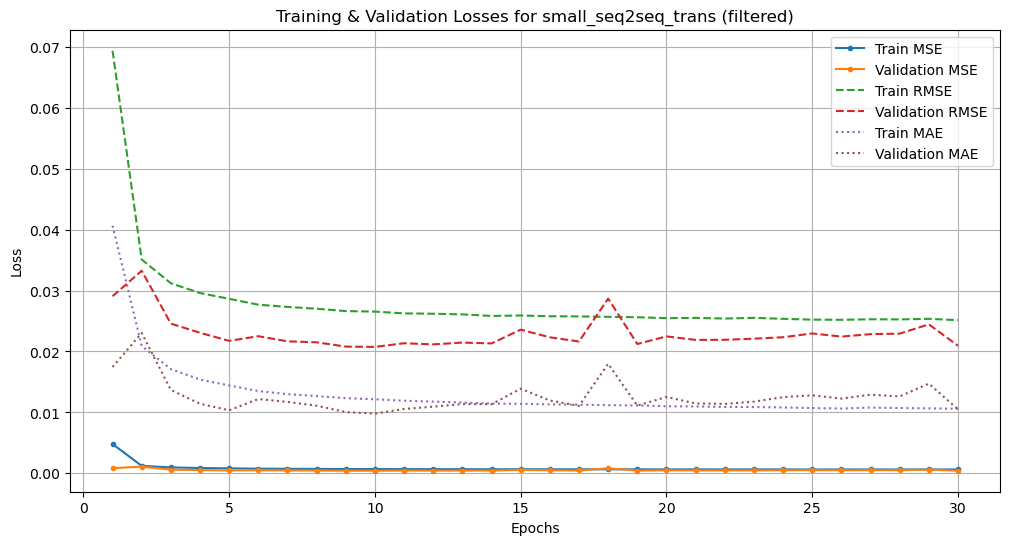

In [7]:
# plot losses for the best model based on MSE

plot_model_losses(best_model_data)

### Results for the best model: Deeper Autoregressive LSTM 2

In [3]:
file_path = 'deeper_autoreg_lstm_2_results.pkl'

# Open the pickle file
with open(file_path, 'rb') as file:
    results = pickle.load(file)


In [4]:
all_mse = results["all_mse"]
x = results["x"]
y = results["y"]
y_pred = results["y_pred"]
n_samples = len(all_mse)
sorted_indices = np.argsort(all_mse)

In [5]:
percentiles = [10, 30, 50, 80, 90, 95, 99, 99.99, 100]
print("\nMSE percentile summary:\n")
for p in percentiles:
    threshold = np.percentile(all_mse, p)
    print(f"{p:>3}% of samples have MSE ≤ {threshold:.6f}")


MSE percentile summary:

 10% of samples have MSE ≤ 0.000006
 30% of samples have MSE ≤ 0.000015
 50% of samples have MSE ≤ 0.000030
 80% of samples have MSE ≤ 0.000127
 90% of samples have MSE ≤ 0.000313
 95% of samples have MSE ≤ 0.000640
 99% of samples have MSE ≤ 0.002156
99.99% of samples have MSE ≤ 0.429050
100% of samples have MSE ≤ 4.922836


In [6]:
scaler = load_scaler(filtered=True)

groups = {
    "Best": sorted_indices[:3],
    "Q1": sorted_indices[n_samples//4:n_samples//4+3],
    "Median": sorted_indices[n_samples//2:n_samples//2+3],
    "Q3": sorted_indices[3*n_samples//4:3*n_samples//4+3],
    "Worst": sorted_indices[-3:]
}

group_means_dict = {}

print("\n=== Haversine Distance Evaluation by Groups ===")

for group_name, indices in groups.items():
    group_means = []

    print(f"\n### {group_name} group ###")

    for idx in indices:

        y_true_scaled = y[idx]
        y_pred_scaled = y_pred[idx]


        y_true_unscaled = scaler.inverse_transform(y_true_scaled)
        y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

        # Compute Haversine
        dists_km, mean_hav_km = haversine_np(y_true_unscaled, y_pred_unscaled)

        # Save group mean
        group_means.append(mean_hav_km)

        # --- Pretty step-wise print for groups ---
        print(f"\nSample {idx} (MSE={all_mse[idx]:.6f}) – Haversine per step:")
        for step, d in enumerate(dists_km, start=1):
            print(f"  Step {step:02d} → {d:10.6f} km")

        print(f"  -> Mean Haversine for this sample: {mean_hav_km:.6f} km")

        group_means_dict[group_name] = group_means


=== Haversine Distance Evaluation by Groups ===

### Best group ###

Sample 358807 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.108377 km
  Step 02 →   0.014771 km
  Step 03 →   0.233176 km
  Step 04 →   0.206272 km
  Step 05 →   0.040147 km
  Step 06 →   0.207699 km
  Step 07 →   0.260574 km
  Step 08 →   0.208669 km
  Step 09 →   0.184193 km
  Step 10 →   0.152361 km
  -> Mean Haversine for this sample: 0.161624 km

Sample 269499 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.271715 km
  Step 02 →   0.209799 km
  Step 03 →   0.227926 km
  Step 04 →   0.066838 km
  Step 05 →   0.092511 km
  Step 06 →   0.079194 km
  Step 07 →   0.089335 km
  Step 08 →   0.112087 km
  Step 09 →   0.103294 km
  Step 10 →   0.088092 km
  -> Mean Haversine for this sample: 0.134079 km

Sample 16523 (MSE=0.000000) – Haversine per step:
  Step 01 →   0.185409 km
  Step 02 →   0.144717 km
  Step 03 →   0.129129 km
  Step 04 →   0.128227 km
  Step 05 →   0.242107 km
  Step 06 →   0.112114 km
  


Plotting 3 samples from Best group:


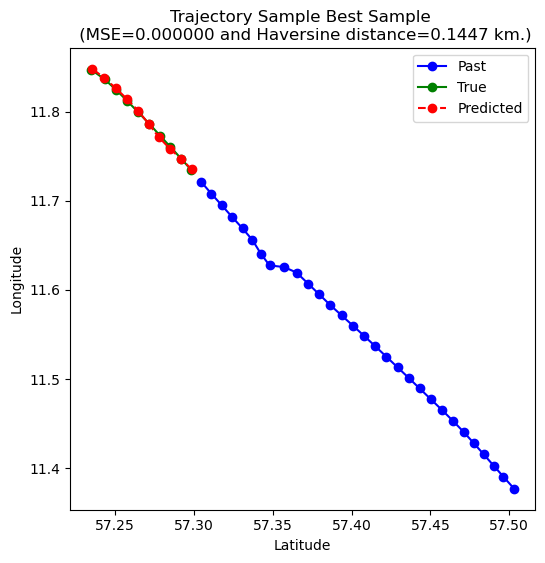

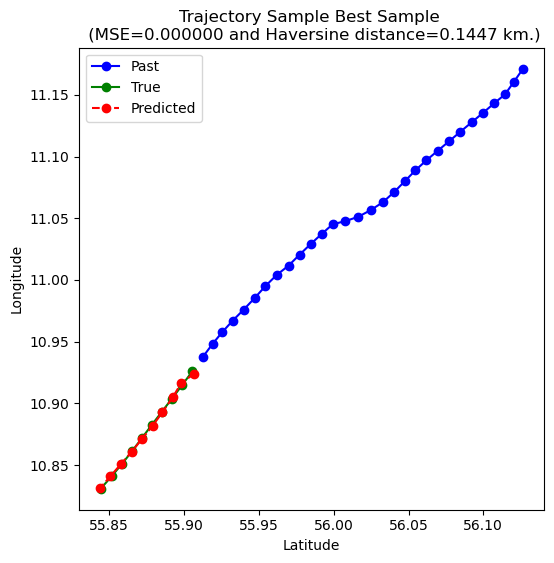

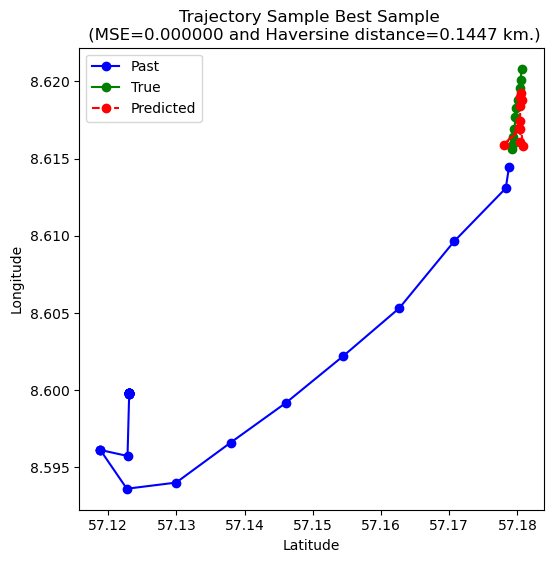


Plotting 3 samples from Q1 group:


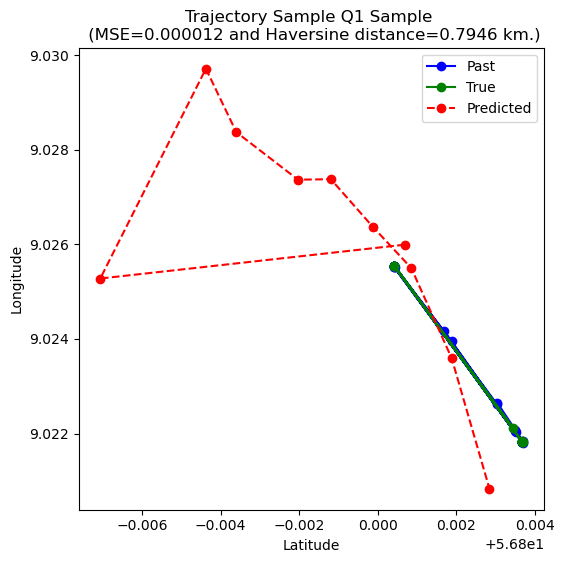

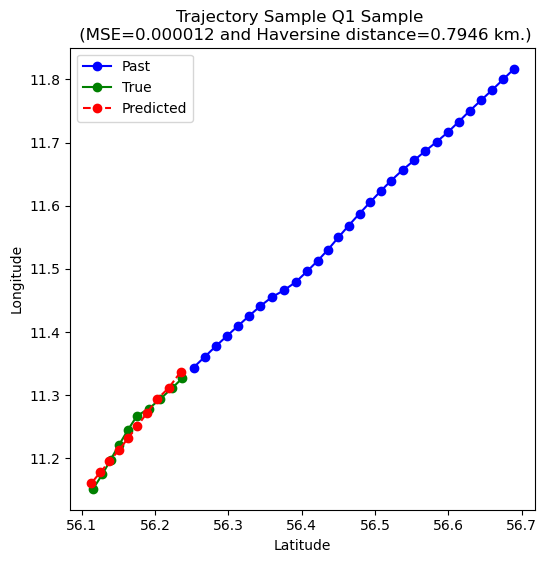

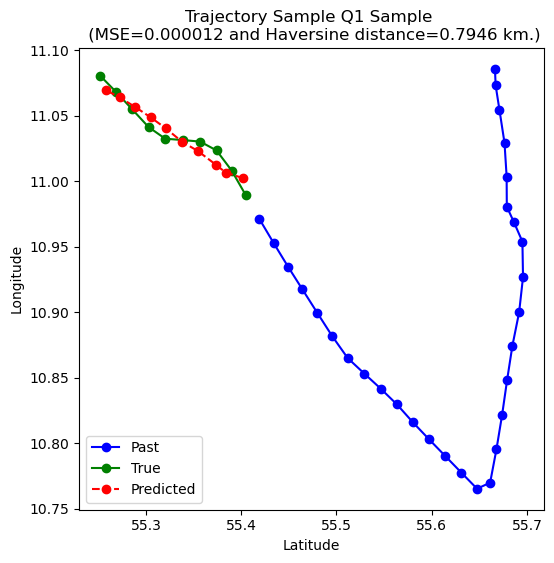


Plotting 3 samples from Median group:


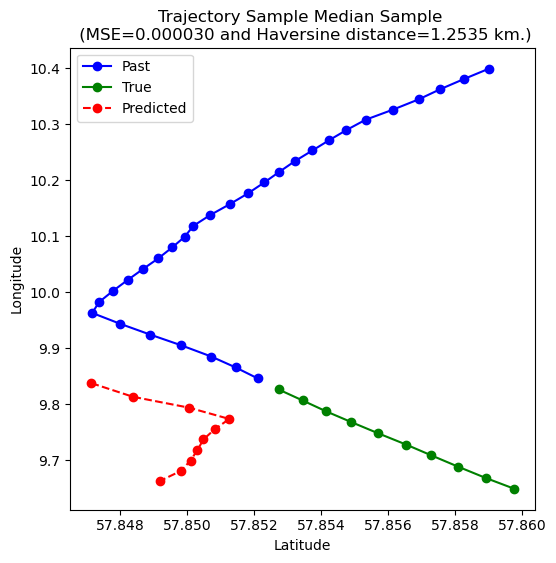

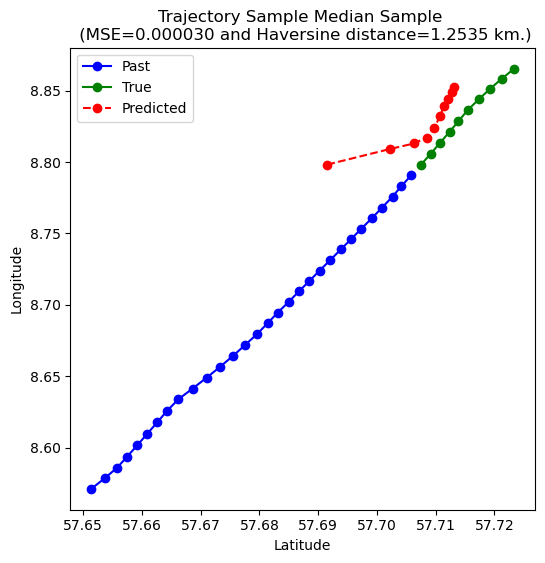

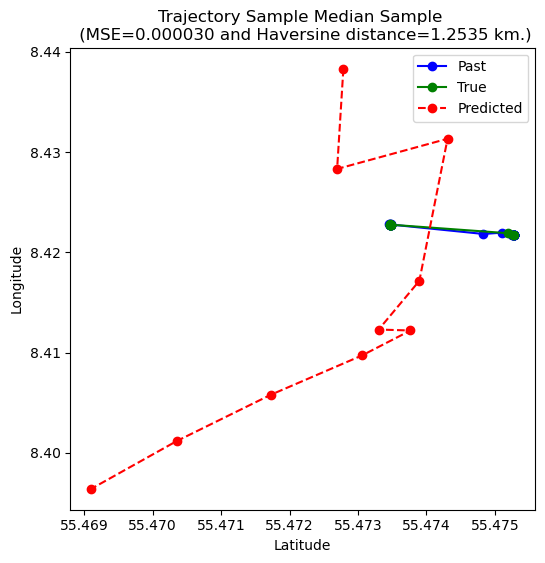


Plotting 3 samples from Q3 group:


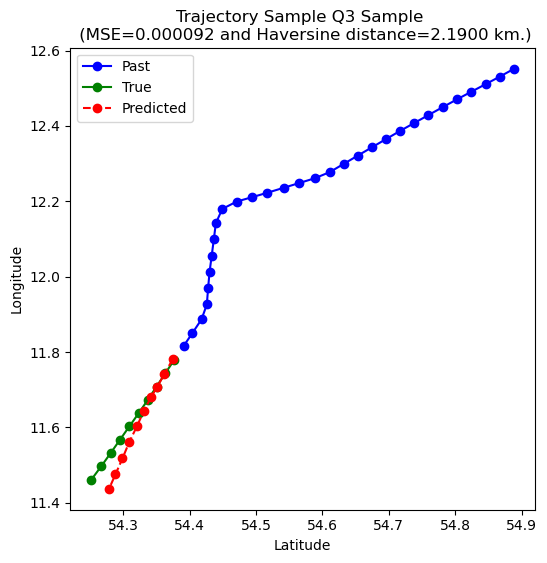

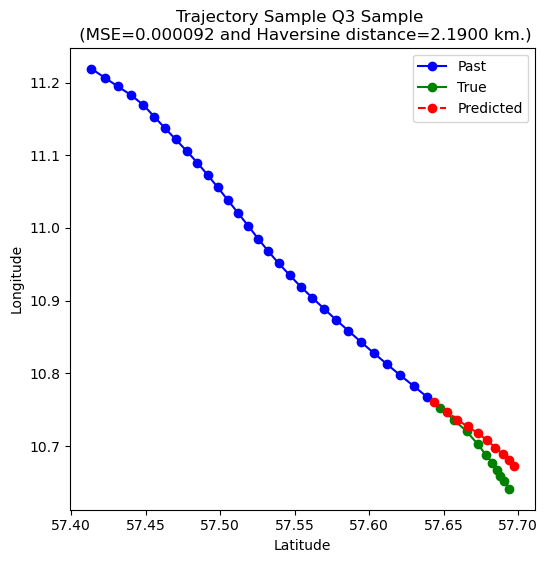

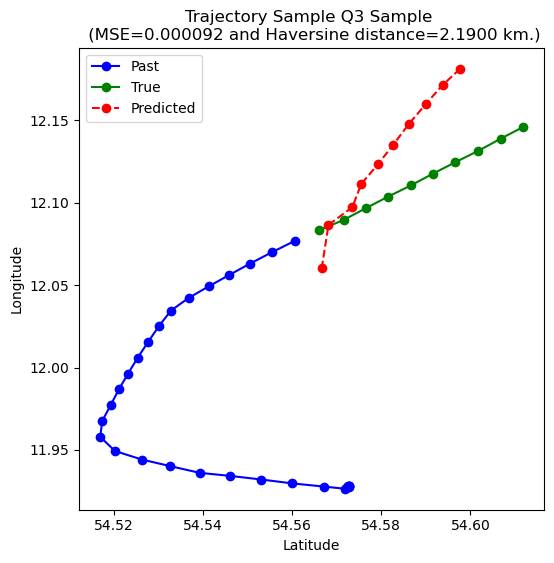


Plotting 3 samples from Worst group:


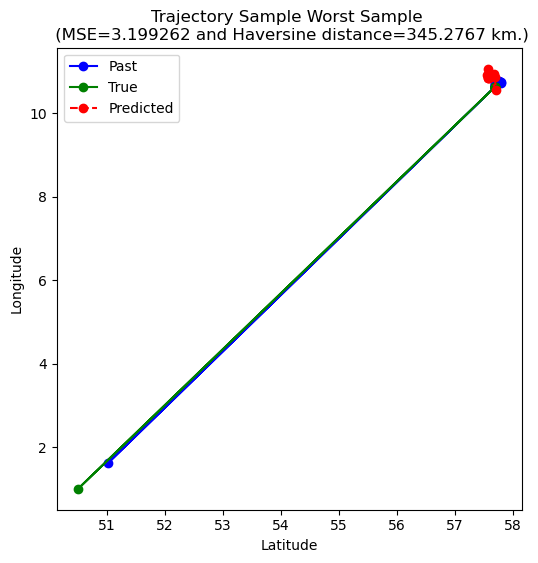

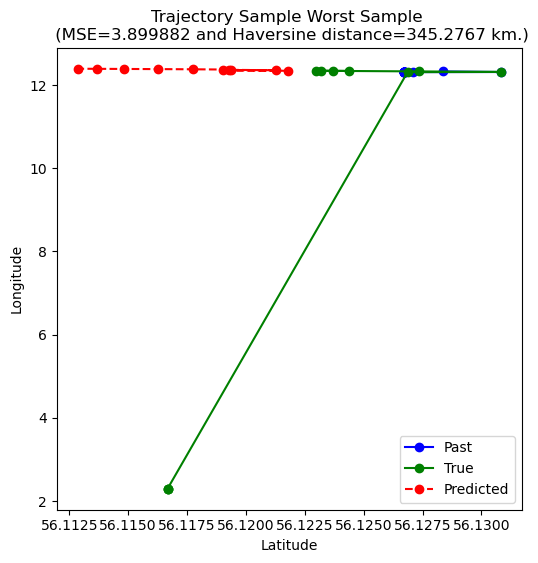

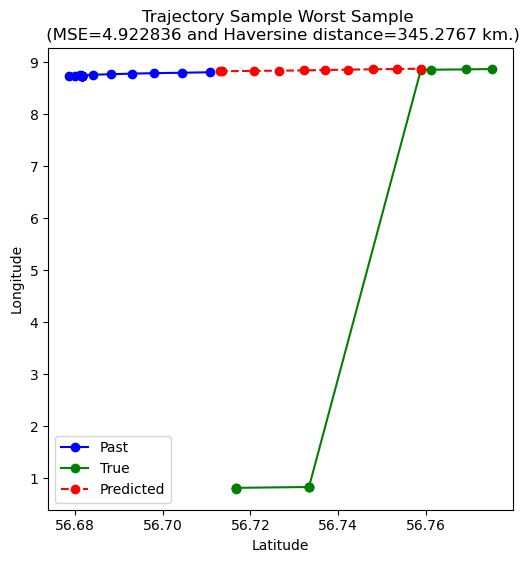

In [ ]:
plot_samples(x,y, y_pred, all_mse, groups, group_means_dict, scaler=scaler)

### Results for the X Transformer

In [ ]:
file_path = 'X.pkl'

# Open the pickle file
with open(file_path, 'rb') as file:
    results = pickle.load(file)


In [ ]:
all_mse = results["all_mse"]
x = results["x"]
y = results["y"]
y_pred = results["y_pred"]
n_samples = len(all_mse)
sorted_indices = np.argsort(all_mse)

In [ ]:
percentiles = [10, 30, 50, 80, 90, 95, 99, 99.99, 100]
print("\nMSE percentile summary:\n")
for p in percentiles:
    threshold = np.percentile(all_mse, p)
    print(f"{p:>3}% of samples have MSE ≤ {threshold:.6f}")

In [ ]:
scaler = load_scaler(filtered=True)

groups = {
    "Best": sorted_indices[:3],
    "Q1": sorted_indices[n_samples//4:n_samples//4+3],
    "Median": sorted_indices[n_samples//2:n_samples//2+3],
    "Q3": sorted_indices[3*n_samples//4:3*n_samples//4+3],
    "Worst": sorted_indices[-3:]
}

group_means_dict = {}

print("\n=== Haversine Distance Evaluation by Groups ===")

for group_name, indices in groups.items():
    group_means = []

    print(f"\n### {group_name} group ###")

    for idx in indices:

        y_true_scaled = y[idx]
        y_pred_scaled = y_pred[idx]


        y_true_unscaled = scaler.inverse_transform(y_true_scaled)
        y_pred_unscaled = scaler.inverse_transform(y_pred_scaled)

        # Compute Haversine
        dists_km, mean_hav_km = haversine_np(y_true_unscaled, y_pred_unscaled)

        # Save group mean
        group_means.append(mean_hav_km)

        # --- Pretty step-wise print for groups ---
        print(f"\nSample {idx} (MSE={all_mse[idx]:.6f}) – Haversine per step:")
        for step, d in enumerate(dists_km, start=1):
            print(f"  Step {step:02d} → {d:10.6f} km")

        print(f"  -> Mean Haversine for this sample: {mean_hav_km:.6f} km")

        group_means_dict[group_name] = group_means

In [ ]:
plot_samples(x,y, y_pred, all_mse, groups, group_means_dict, scaler=scaler)